In [15]:
# Imports 
%run ../imports.ipynb
%matplotlib inline

# from pyedgar.utilities import (edgarweb, localstore, htmlparse, plaintext, forms)
from pyedgar.filing import Filing
from pyedgar.index import EDGARIndex
IDX_ROOT = os.path.dirname(EDGARIndex().indices['form_10-K.tab'])

from psycopg2 import connect as pc

def intornan(val):
    try:
        return int(val)
    except ValueError:
        pass
    return np.nan

# Load password file for wrds, alternatively set the environment variables externally
# this is just new-line delimited "user \n password" in a file called wrds.pwd
pwd_path = '~/Dropbox/Documents/Personal/config/wrds.pwd'#, '~/wrds.pwd'
try:
    with open(os.path.expanduser(pwd_path), 'r', encoding='utf-8') as fh:
        wrds_user, wrds_password = fh.read().strip().split('\n')
        os.environ['WRDS_USER'] = wrds_user
        os.environ['WRDS_PASSWORD'] = wrds_password
except FileNotFoundError:
    pass

def string_to_int(x):
    """convert cik and gvkey to integers (ignoring nan and None)"""
    try:
        return int(x)
    except ValueError:
        return np.nan

class wrds_connection(object):
    wrds_user = None
    wrds_password = None
    psql_connection = None
    pool = None
    engine = None

    def __init__(self, wrds_user=None, wrds_password=None):
        self.wrds_user = wrds_user or os.environ.get('WRDS_USER', None)
        self.wrds_password = wrds_password or os.environ.get('WRDS_PASSWORD', None)

    def connect(self):
        self.psql_connection = pc(
            dbname="wrds",
            user=self.wrds_user,
            host='wrds-pgdata.wharton.upenn.edu',
            port=9737,
            password=self.wrds_password,
            sslmode='require')

        return self.psql_connection

    def get_engine(self):
        if self.pool is None:
            self.pool = pool.QueuePool(self.connect)

        self.engine = create_engine("postgresql://", pool=self.pool)

        return self.engine

    def __enter__(self):
        if self.psql_connection is None:
            self.connect()

        return self

    def __exit__(self, *args, **kwargs):
        try:
            self.psql_connection.close()
            self.psql_connection = None
        except:
            pass

    def read_sql(self, sql_statement, *args, **kwargs):
        return pd.read_sql(sql_statement, self.psql_connection, *args, **kwargs)

Set logger to WARNING, call logger.setLevel(logging.INFO) to see more logging output.
IPython: 7.13.0
Numpy (np): 1.18.1
Scipy (sp, stats): 1.4.1
Pandas (pd): 1.0.2
Scikit-Learn (sk): 0.22.1
Statsmodels (sm): 0.11.0
Patsy (pt): 0.5.1
MatPlotLib (mpl, plt): 3.1.3
Seaborn (sns): 0.10.0
SQLAlchemy (sa): 1.3.15
Gensim: 3.8.0


# Load the EDGAR filings

Read from form_10.periods.tab
Missing period: 221,627/962,583 (23.0%)
Missing sic: 196,916/962,583 (20.5%)
Filing delayed >1yr: 6,366/962,583 (0.7%)
Period after 2005: 430,460/962,583 (44.7%)
Num: 962,583	Start: 1986-02-28	End: 2018-12-31


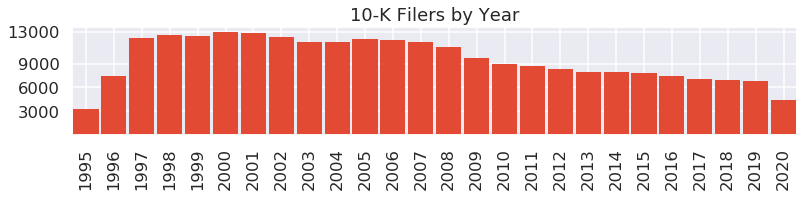

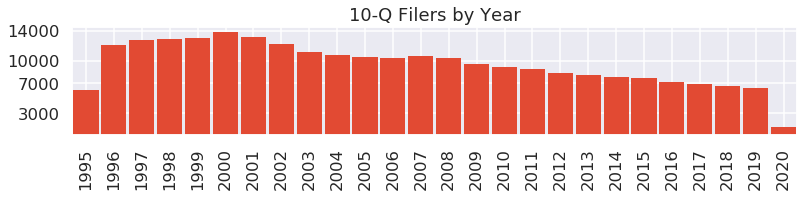

In [2]:
if "Load Filings from EDGAR: df_edgar":
#     all_ciks = pd.read_csv(os.path.join(IDX_ROOT, 'all_filings.tab'), sep='\t', usecols=['CIK', ]).CIK.unique()
    df_edgar = pd.concat([EDGARIndex()['10-K'], EDGARIndex()['10-Q']])
    all_ciks = df_edgar.cik.unique()
    df_edgar = (df_edgar[~df_edgar['form'].str.contains('/A')]
                        .sort_values(['cik', 'filedate'])
                        .reset_index(drop=True))
    df_edgar['K'] = df_edgar.form.str.contains('K')
    
    # Now add in the periods from previous scrapes
    df_period = EDGARIndex()['10.periods']
    print("Read from", [x for x in EDGARIndex().indices if 'form_10.periods.tab' in x][0])
    for c in 'filedate period'.split():
        df_period[c] = pd.to_datetime(df_period[c])

    df_edgar = df_edgar.merge(df_period, on='cik accession'.split(),
                              how='left', suffixes=('', '_period'))
    for c in df_edgar.columns:
        if re.search(r'_period$', c):
            del df_edgar[c]
    
    # Output some stats.
    _tot = _tot_df_edgar = len(df_edgar)
    print("Missing period: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[df_edgar.period.isnull()]), _tot, 
          100.*len(df_edgar[df_edgar.period.isnull()])/_tot))
    print("Missing sic: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[df_edgar.sic.isnull()]), _tot, 
          100.*len(df_edgar[df_edgar.sic.isnull()])/_tot))
    print("Filing delayed >1yr: {:,d}/{:,d} ({:.1f}%)".format(
          len(df_edgar[(df_edgar.filedate - df_edgar.period)/TD_DAY > 365]), _tot, 
          100.*len(df_edgar[(df_edgar.filedate - df_edgar.period)/TD_DAY > 365])/_tot))

    _n = len(df_edgar[df_edgar.period > dt.datetime(2005, 1, 1)])
    print("Period after 2005: {:,d}/{:,d} ({:.1f}%)".format(_n, _tot, _n/_tot*100))
    print("Num: {:,}\tStart: {:%Y-%m-%d}\tEnd: {:%Y-%m-%d}".format(
          len(df_edgar), df_edgar.period.min(), df_edgar.period.max(), ))
    
    _d = df_edgar['cik filedate form'.split()].copy()
    _d['yr'] = _d.filedate.dt.year
    timehist(_d[_d.form.str.contains('K')].drop_duplicates('cik yr'.split()).filedate)
    plt.title("10-K Filers by Year")
    timehist(_d[_d.form.str.contains('Q')].drop_duplicates('cik yr'.split()).filedate)
    plt.title("10-Q Filers by Year")
    del _d

In [ ]:
if not "Add Periods":
    RE_SIC = re.compile('\d{4}')
    
    last_i = -1
    new_data = []
    _tmpdf = df_edgar[df_edgar.period.isnull()]
    for i,row in tqdm(_tmpdf[_tmpdf.index > last_i].iterrows(), total=len(_tmpdf[_tmpdf.index > last_i])):
        try:
            ret = {'cik':row.cik, 'accession':row.accession}
            filing = Filing(ret['cik'], ret['accession'])

            if not filing.headers:
                continue

            period = (filing.headers.get('period', None) or 
                      filing.headers.get('conformed-period-of-report', None))

            if period and len(period) == 8:
                ret['period'] = dt.date(int(period[:4]), 
                                        int(period[4:6]),
                                        int(period[-2:]))

            sic = (filing.headers.get('assigned-sic', None) or 
                   filing.headers.get('standard-industrial-classification', None))
            try:
                ret['sic'] = int(RE_SIC.search(sic).group(0))
            except:
                pass

            if period or sic:
                new_data.append(ret)
        except Exception as e:
            print("Exception:", e)
    
    # Now add these new SICs to the dataframe
    if new_data:
        tmpdf = pd.DataFrame(new_data)            
        print("Adding {} rows to df_edgar".format(len(new_data)))

        print("Before: ", len(df_edgar[df_edgar.sic.isnull()]),'/',len(df_edgar),
              100*len(df_edgar[df_edgar.sic.isnull()])/len(df_edgar))
        df_edgar = df_edgar.merge(tmpdf, on='cik accession'.split(), 
                                  how='left', suffixes=('', '_new'))

        for c in 'sic period'.split():
            df_edgar[c] = df_edgar[c].fillna(df_edgar[c+'_new'])
            del df_edgar[c+'_new']

        df_edgar['sic'] = df_edgar['sic'].apply(intornan)
        df_edgar['period'] = pd.to_datetime(df_edgar['period'])
        
        print("After: ", len(df_edgar[df_edgar.sic.isnull()]),'/',len(df_edgar),
              100*len(df_edgar[df_edgar.sic.isnull()])/len(df_edgar))

        df_edgar.sort_values('cik filedate'.split(), inplace=True)

        _fnam = 'form_10.periods.{:%Y%m%d}.tab'.format(dt.date.today())
        df_edgar.to_csv(os.path.join(IDX_ROOT, _fnam), sep='\t', index=False)

    df_edgar['sic'] = df_edgar.groupby('cik').sic.ffill()
    df_edgar['sic'] = df_edgar.groupby('cik').sic.bfill()

In [114]:
if not "Overwrite main periods file":
    assert os.path.exists(os.path.join(IDX_ROOT, _fnam))
    _fnam_master = 'form_10.periods.tab'
    import shutil
    shutil.copy2(os.path.join(IDX_ROOT, _fnam), os.path.join(IDX_ROOT, _fnam_master))

###### Error Checking

In [117]:
row.cik, row.accession

(1797956, '0001493152-20-000097')

In [118]:
filing

<EDGAR filing (1797956/0001493152-20-000097) Headers:True, Text:True, Documents:False>

In [119]:
ret

{'cik': 1797956,
 'accession': '0001493152-20-000097',
 'period': datetime.date(2019, 10, 31),
 'sic': 100}

In [74]:
if not filing.headers:
    raise ValueError("No HEaders")

period = (filing.headers.get('period', None) or 
          filing.headers.get('conformed-period-of-report', None))
print("period", period)
if period and len(period) == 8:
    ret['period'] = dt.date(int(period[:4]), 
                            int(period[4:6]),
                            int(period[-2:]))
    print("ret['period']", ret['period'])

sic = (filing.headers.get('assigned-sic', None) or 
       filing.headers.get('standard-industrial-classification', None))
print("sic", sic)
try:
    ret['sic'] = int(RE_SIC.search(sic).group(0))
    print("ret['sic']", ret['sic'])
except:
    pass


period 20190930
ret['period'] 2019-09-30
sic REAL ESTATE INVESTMENT TRUSTS [6798]
ret['sic'] 6798


# Load the compustat fundamentals

In [120]:
if "GVKEY-CIK link: df_hist":
    ch_lookup_query = (
        'SELECT gvkey::INTEGER '
        ',  hcik::INTEGER AS cik '
        ',  hipodate AS ipo_date '
        ',  hdldte AS crsp_valid_date '
        ',  hchgdt AS link_start '
        ',  hchgenddt AS link_end '
        ',  hfyrc AS fyr '
        ',  hsic AS sic '
        ',  hggroup as gics_group '
        ',  hgind as gics_ind '
        ',  hgsector as gics_sector '
        ',  hgsubind as gics_subind '
        'FROM crsp.comphist '
        'ORDER BY gvkey, link_start')

    with wrds_connection() as conn:
        df_hist = conn.read_sql(ch_lookup_query)
        df_hist['link_start'] = df_hist.link_start.fillna(MIN_DATE)
        df_hist['link_end'] = df_hist.link_end.fillna(MAX_DATE)

    for c in 'ipo_date crsp_valid_date link_start link_end'.split():
        df_hist[c] = pd.to_datetime(df_hist[c])
    
    for c in 'cik sic gics_group gics_ind gics_sector gics_subind'.split():
        df_hist[c] = df_hist.groupby('gvkey')[c].ffill()
        df_hist[c] = df_hist.groupby('gvkey')[c].bfill()
        df_hist[c] = df_hist[c].apply(intornan)
    
    df_hist = df_hist[df_hist['cik'].notnull()].reset_index(drop=True)

In [7]:
if not "Write out GVKEY-CIK link file":
    df_hist.to_stata(os.path.join(SHARED_DATA_ROOT, 'gvkey_cik_link.dta'), write_index=False)

In [121]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in COMPHIST: {len(df_hist[df_hist.cik.notnull()].cik.unique()):,d}')

_d = df_hist[df_hist.cik.notnull() & ~df_hist.cik.isin(all_ciks)]
print(f'Number CIKs in COMPHIST, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_hist):4.2f}% link obs)')

_d = df_hist[df_hist.cik.notnull() & ~df_hist.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in COMPHIST, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_hist):4.2f}% link obs)')

Number unique CIKs in EDGAR: 42,830
Number unique CIKs in EDGAR (with at least one 10-K/Q): 42,753
Number unique CIKs in COMPHIST: 34,138
Number CIKs in COMPHIST, not in EDGAR: 13,369 (32.03% link obs)
Number CIKs in COMPHIST, not in EDGAR (w/ 10-K/Q): 13,381 (32.05% link obs)


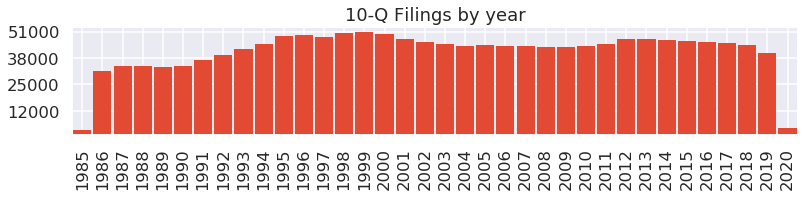

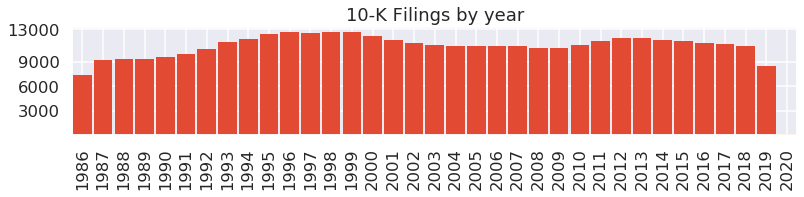

In [122]:
if "Load Compustat from WRDS postgres server: df_compq/df_compa":
    sql_fundq = (
        "SELECT a.gvkey, a.datadate, a.fyearq, a.rdq "
        "    ,a.fyr, a.fqtr, a.datafqtr, a.datacqtr, b.fundq_start "
        "    ,a.tic, a.cusip, a.conm, a.atq, a.niq "
        "    ,a.prccq * a.cshoq  AS mcapq "
        "FROM comp.fundq a "
        "LEFT JOIN (SELECT gvkey, MIN(datadate) AS fundq_start "
        "           FROM comp.fundq GROUP BY gvkey) b "
        "    ON (a.gvkey = b.gvkey) "
        "WHERE a.INDFMT = 'INDL' "
        "    AND a.DATAFMT = 'STD' "
        "    AND a.POPSRC = 'D' "
        "    AND a.CONSOL = 'C' "
        "    AND a.fyearq > 1985 "
        "ORDER BY a.gvkey, a.datafqtr, a.datacqtr")
    
    sql_funda = (
        "SELECT a.gvkey, a.datadate, a.fyear "
        "    ,a.fyr, a.sich, a.cik, b.funda_start "
        "    ,a.tic, a.cusip, a.conm, a.fic, a.at, a.ni "
        "    ,a.prcc_f * a.csho  AS mcap "
        "FROM comp.funda a "
        "LEFT JOIN (SELECT gvkey, MIN(datadate) AS funda_start "
        "           FROM comp.funda GROUP BY gvkey) b "
        "    ON (a.gvkey = b.gvkey) "
        "WHERE a.INDFMT = 'INDL' "
        "    AND a.DATAFMT = 'STD' "
        "    AND a.POPSRC = 'D' "
        "    AND a.CONSOL = 'C' "
        "    AND a.fyear > 1985 "
        "ORDER BY a.gvkey, a.fyear, a.fyr")
    
    with wrds_connection() as conn:
        df_fundq = conn.read_sql(sql_fundq)
        for c in 'datadate rdq fundq_start'.split():
            df_fundq[c] = pd.to_datetime(df_fundq[c])

        timehist(df_fundq.datadate)
        plt.title("10-Q Filings by year")
        
        df_funda = conn.read_sql(sql_funda)
        for c in 'datadate funda_start'.split():
            df_funda[c] = pd.to_datetime(df_funda[c])
        
        timehist(df_funda.datadate)
        plt.title("10-K Filings by year")

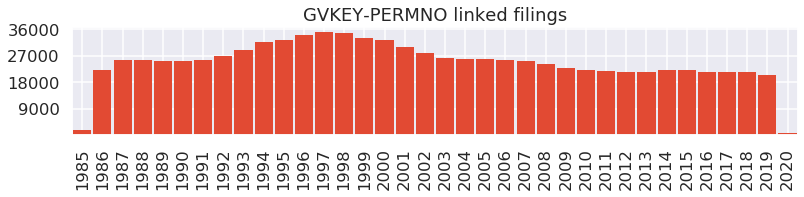

In [123]:
if "GVKEY-PERMNO link: df_crsp":
    with wrds_connection() as conn:
        df_ccm = conn.read_sql('SELECT * FROM crsp.ccmxpf_linktable')
        for c in 'linkdt linkenddt'.split():
            df_ccm[c] = pd.to_datetime(df_ccm[c])

    df_ccm = df_ccm[df_ccm.linktype.str.contains(r'L[UC]', regex=True)]
    df_ccm['linkdt'] = df_ccm['linkdt'].fillna(MIN_DATE)
    df_ccm['linkenddt'] = df_ccm['linkenddt'].fillna(MAX_DATE)
    
    _d = (pd.merge(pd.concat([df_funda['gvkey datadate'.split()],
                              df_fundq['gvkey datadate'.split()]], sort=False).drop_duplicates(),
                   df_ccm['gvkey linkprim liid lpermno lpermco linkdt linkenddt'.split()],
                   on='gvkey', how='inner')
            .sort_values('gvkey datadate linkdt linkprim'.split()))

    _d = (_d[_d.datadate.between(_d.linkdt, _d.linkenddt)]
            .sort_values('gvkey datadate linkprim'.split(), ascending=False)
            .reset_index(drop=True) # reset the index to be 1-N
            .reset_index()) # Add that 1-N to the dataframe
    # Now subtract the gvkey-datadate min, resulting in numbered permnos by linkprim
    _d['index'] -= _d.groupby('gvkey datadate'.split())['index'].transform(min) - 1

    # Now pivot those gvkey-datadate rows into columns with numbered permnos
    df_crsp = (_d.pivot_table(index='gvkey datadate'.split(),
                              columns='index',
                              values='lpermco lpermno'.split())
                 .reset_index()) # Reset index moves gvkey-datadate into the dataframe
    
    df_crsp.columns = [f"{a.replace('lperm', 'perm')}{str(b).replace('1', '')}"
                       for a,b in df_crsp.columns]
    
    df_crsp['gvkey'] = df_crsp.gvkey.astype(int)
    timehist(df_crsp[df_crsp.permno.notnull()].datadate)
    _ = plt.title('GVKEY-PERMNO linked filings')

Matched 99,901 firm-years to comphist
Kept 99,901 CIK firm-years from comphist
Kept 212,252 CIK firm-years from comphist after filling
Kept 319,836 CIK firm-years after combination


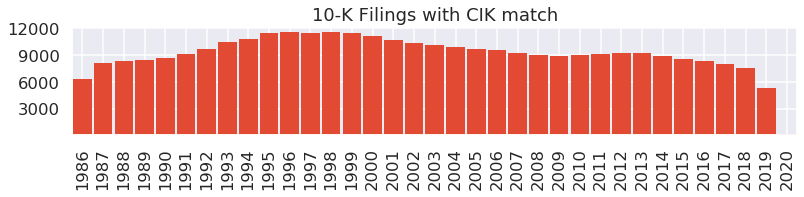

In [125]:
if "Clean Compustat tables: df_compa":
    _uniquekeys = 'gvkey fyear fyr datadate'.split()
    
    df_compa = (pd.merge(df_funda,
                         df_fundq.loc[df_fundq.fyearq.notnull() & df_fundq.fyr.notnull(),
                                      'gvkey fyearq fyr datadate fqtr datafqtr '
                                      'datacqtr rdq fundq_start'.split()],
                         left_on='gvkey fyear fyr datadate'.split(),
                         right_on='gvkey fyearq fyr datadate'.split(),
                         how='left', 
                         suffixes=('', '_errorize'))
                  .sort_values('gvkey fyear fyr'.split()))
    
    assert(all(['_errorize' not in c for c in df_compa.columns]))
    
    for c in 'gvkey fyear fyr sich cik'.split():
        df_compa[c] = df_compa[c].astype(float).apply(intornan)

    _prelen = len(df_compa)
    _predups = len(df_compa[df_compa.duplicated(_uniquekeys)])
    assert(0 == _predups)

    _compa = pd.merge(df_compa, df_hist, on='gvkey', how='inner', suffixes=('', '_comphist'))
    _compa = _compa[_compa.datadate.between(_compa.link_start, _compa.link_end)]
    # Rename sic to sic_comphist
    _compa.columns = [c if c != 'sic' else 'sic_comphist' for c in _compa.columns]
    print(f"Matched {len(_compa):,d} firm-years to comphist")
    
    assert(_predups == len(_compa[_compa.duplicated(_uniquekeys)]))

    _compa = (pd.concat([_compa, df_compa], sort=False)
                .sort_values(_uniquekeys + ['cik_comphist', ])
                .drop_duplicates(_uniquekeys)
                .sort_values(_uniquekeys)
                .reset_index(drop=True))
    print(f"Kept {len(_compa[_compa.cik_comphist.notnull()]):,d} CIK firm-years from comphist")

    # don't do .bfill() here, that breaks on groupby apparently.
    # Doesn't sort properly.
    cols = 'gics_group gics_ind gics_sector gics_subind cusip'.split()
    _compa[cols] = _compa.groupby('gvkey')[cols].fillna(method='ffill')
    _compa[cols] = _compa.groupby('gvkey')[cols].fillna(method='bfill')

    _compa['cik_comphist'] = _compa.groupby('gvkey').cik_comphist.fillna(method='bfill')
    # _compa['cik_comphist'] = _compa.groupby('gvkey').cik_comphist.fillna(method='ffill')
    print(f"Kept {len(_compa[_compa.cik_comphist.notnull()]):,d} CIK firm-years from comphist after filling")

    assert(_prelen == len(_compa))
    
    df_compa = _compa.merge(df_crsp, how='left')
    assert(_prelen == len(df_compa))
    
    del _compa
    for c in 'fyr_comphist crsp_valid_date link_start link_end fyearq'.split():
        del df_compa[c]

    df_compa['cik_funda'] = df_compa['cik']
    df_compa['cik'] = df_compa.cik_comphist.fillna(df_compa.cik_funda)
    print(f"Kept {len(df_compa[df_compa.cik.notnull()]):,d} CIK firm-years after combination")
    
    timehist(df_compa[df_compa.cik.notnull()].datadate)
    _ = plt.title('10-K Filings with CIK match')

In [126]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in FUNDA: {len(df_compa[df_compa.cik.notnull()].cik.unique()):,d}')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(all_ciks)]
print(f'Number CIKs in FUNDA, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique()) & (df_compa['at']>0)]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +Assets): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

_d = df_compa[df_compa.cik.notnull() & ~df_compa.cik.isin(df_edgar.cik.unique()) & df_compa.permno.notnull()]
print(f'Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +PERMNO): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compa):4.2f}% firm-years)')

Number unique CIKs in EDGAR: 42,830
Number unique CIKs in EDGAR (with at least one 10-K/Q): 42,753
Number unique CIKs in FUNDA: 27,175
Number CIKs in FUNDA, not in EDGAR: 8,700 (19.97% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q): 8,711 (19.99% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +Assets): 7,528 (14.45% firm-years)
Number CIKs in FUNDA, not in EDGAR (w/ 10-K/Q & +PERMNO): 5,702 (11.62% firm-years)


Matched 403,193 firm-years to comphist
Kept 403,193 CIK firm-years from comphist
Kept 876,843 CIK firm-years from comphist after filling
Kept 1,249,079 CIK firm-years after combination


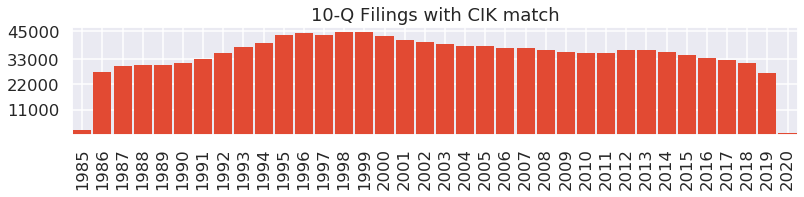

In [127]:
if "Clean Compustat tables: df_compq":
    _uniquekeys = 'gvkey fyearq fyr fqtr'.split()
    
    df_compq = (pd.merge(df_fundq,
                         df_funda.loc[df_funda.fyear.notnull() & df_funda.fyr.notnull(),
                                      'gvkey fyear fyr funda_start sich cik'.split()],
                         left_on='gvkey fyearq fyr'.split(),
                         right_on='gvkey fyear fyr'.split(),
                         how='left', 
                         suffixes=('', '_errorize'))
                  .query("gvkey != '020966'") # Canadian company that FUNDQ duplicates
                  .query("fqtr == fqtr") # drop missing fiscal quarters
                  .sort_values('gvkey fyearq fyr fqtr'.split())
                  .drop_duplicates(_uniquekeys))
    
    assert(all(['_errorize' not in c for c in df_compq.columns]))
    
    for c in 'gvkey fyearq fyr fqtr sich cik'.split():
        df_compq[c] = df_compq[c].astype(float).apply(intornan)

    _prelen = len(df_compq)
    assert(0 == len(df_compq[df_compq.duplicated(_uniquekeys)]))

    _compq = pd.merge(df_compq, df_hist, on='gvkey', how='inner', suffixes=('', '_comphist'))
    _compq = _compq[_compq.datadate.between(_compq.link_start, _compq.link_end)]
    # Rename sic to sic_comphist
    _compq.columns = [c if c != 'sic' else 'sic_comphist' for c in _compq.columns]
    print(f"Matched {len(_compq):,d} firm-years to comphist")
    
    # We didn't add any duplicates did we?
    assert(0 == len(_compq[_compq.duplicated(_uniquekeys)]))

    _compq = (pd.concat([_compq, df_compq], sort=False)
                .sort_values(_uniquekeys + ['cik_comphist', ])
                .drop_duplicates(_uniquekeys)
                .sort_values(_uniquekeys)
                .reset_index(drop=True))
    print(f"Kept {len(_compq[_compq.cik_comphist.notnull()]):,d} CIK firm-years from comphist")

    # don't do .bfill() here, that breaks on groupby apparently.
    # Doesn't sort properly.
    for c in 'gics_group gics_ind gics_sector gics_subind cusip'.split():
        _compq[c] = _compq.groupby('gvkey')[c].fillna(method='ffill')
        _compq[c] = _compq.groupby('gvkey')[c].fillna(method='bfill')

    _compq['cik_comphist'] = _compq.groupby('gvkey').cik_comphist.fillna(method='bfill')
    # _compq['cik_comphist'] = _compq.groupby('gvkey').cik_comphist.fillna(method='ffill')
    print(f"Kept {len(_compq[_compq.cik_comphist.notnull()]):,d} CIK firm-years from comphist after filling")

    assert(_prelen == len(_compq))

    df_compq = _compq.merge(df_crsp, how='left')
    assert(_prelen == len(df_compq))
    
    del _compq
    for c in 'fyr_comphist crsp_valid_date link_start link_end fyear'.split():
        del df_compq[c]

    df_compq['cik_funda'] = df_compq['cik']
    df_compq['cik'] = df_compq.cik_comphist.fillna(df_compq.cik_funda)
    
    timehist(df_compq[df_compq.cik.notnull()].datadate)
    plt.title('10-Q Filings with CIK match')
    
    print(f"Kept {len(df_compq[df_compq.cik.notnull()]):,d} CIK firm-years after combination")

In [128]:
# Link Stats
print(f'Number unique CIKs in EDGAR: {len(all_ciks):,d}')
print(f'Number unique CIKs in EDGAR (with at least one 10-K/Q): {len(df_edgar.cik.unique()):,d}')
print(f'Number unique CIKs in FUNDQ: {len(df_compq[df_compq.cik.notnull()].cik.unique()):,d}')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(all_ciks)]
print(f'Number CIKs in FUNDQ, not in EDGAR: '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique())]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q): '
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique()) & (df_compq.atq>0)]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +Assets): '      
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

_d = df_compq[df_compq.cik.notnull() & ~df_compq.cik.isin(df_edgar.cik.unique()) & df_compq.permno.notnull()]
print(f'Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +PERMNO): '      
      f'{len(_d.cik.unique()):,d} ({100*len(_d)/len(df_compq):4.2f}% firm-years)')

Number unique CIKs in EDGAR: 42,830
Number unique CIKs in EDGAR (with at least one 10-K/Q): 42,753
Number unique CIKs in FUNDQ: 27,307
Number CIKs in FUNDQ, not in EDGAR: 8,755 (19.57% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q): 8,766 (19.59% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +Assets): 7,596 (12.14% firm-years)
Number CIKs in FUNDQ, not in EDGAR (w/ 10-K/Q & +PERMNO): 5,825 (11.54% firm-years)


In [15]:
if not "Write fundq.csv out":
    _sel = (df_compq.groupby('gvkey').cik.max() > 0).reset_index()
    _sel = df_compq.gvkey.isin(_sel[_sel.cik].gvkey.unique())
    _sel &= df_compq.fyearq > 1990

    print("Writing {} lines  to: {}".format(len(df_compq[_sel]),
          os.path.join(SHARED_DATA_ROOT, 'fundq.csv')))
    df_compq[_sel].to_csv(os.path.join(SHARED_DATA_ROOT, 'fundq.csv'), index=False)
    
if not "Write funda.csv out":
    _sel = (df_compa.groupby('gvkey').cik.max() > 0).reset_index()
    _sel = df_compa.gvkey.isin(_sel[_sel.cik].gvkey.unique())
    _sel &= df_compa.fyear > 1990
    
    _fpath = os.path.join(SHARED_DATA_ROOT, 'funda_all.csv')

    print("Writing {} lines  to: {}".format(len(df_compa[_sel]), _fpath))
    df_compa[_sel].to_csv(_fpath, index=False)

In [16]:
if not "Emergency clean PostgreSQL connection":
    # If you use with pc() as conn:, it doesn't close the connection
    # Learned this the hard way :(
    # So then I got to learn about too many open connection errors
    # This is the fix for that problem, thanks to:
    # https://stackoverflow.com/a/25067055/1959876
    try:
        conn = pc(dbname="wrds", 
                  user="gaulinmp",
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  password=wrds_password.strip(),
                  sslmode='require')
        
        # Change this to pg_cancel_backend(pid) for more peaceful termination
        df_kill = pd.read_sql("""SELECT pg_terminate_backend(pid)
                                FROM   pg_stat_activity
                                WHERE  usename = 'gaulinmp'
                                AND    pid <> pg_backend_pid();""", conn)
    
    finally:
        conn.close()

# Now merge in EDGAR filings

Merge Form10 to CIK/date (cik / datadate) unique keys: ['gvkey', 'datadate', 'datacqtr']
Step 0: 1,487,783 (0 dups): DF in
Step 1: 53,196,679 (52,239,103 dups): Merge on CIK
Step 2: 33,324,631 (32,370,979 dups): Match Ks with Q4
Step 3: 638,219 (281 dups): Limit on 'close' dates
Step 4: 638,126 (188 dups): Keep single accessions and filedate after datadate
Step 5: 637,938 (0 dups): Keep closest between period and filing
Step 6: 1,487,783 (0 dups): Add matched EDGAR data back to input DF


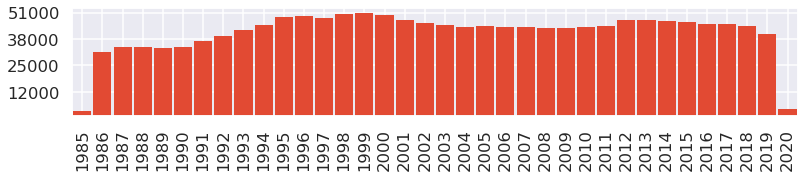

In [134]:
if "Combine EDGAR & Comp/Crsp":
    def merge_form10_to_cik_date(df_with_cik_date,
                                 df_edgar,
                                 cik_var='cik',
                                 date_var='datadate',
                                 unique_keys=None,
                                 period_max_lag=30,
                                 filedate_max_lag=120):
        """
        Take dataframe with CIK and date and add EDGAR data to it.
        Dataframe must have CIK, and datadate and rdq.

        cik_var defaults to `cik`
        unique_keys defaults to 'gvkey datadate datacqtr datafqtr'
        """
        target_len = len(df_with_cik_date)

        _unique = unique_keys or ['gvkey']
        for c in (date_var, 'datacqtr', 'datafqtr', 'fyr'):
            if df_with_cik_date.duplicated(_unique).any():
                if c in df_with_cik_date and c not in _unique:
                    _unique.append(c)

        print(f"Merge Form10 to CIK/date ({cik_var} / {date_var}) unique keys: {_unique}")

        _keepcols = _unique.copy()
        for c in ["fqtr", cik_var]:
            if c in df_with_cik_date and c not in _keepcols:
                _keepcols.append(c)

        _edgar_merge_cols = f'cik accession filedate period'.split()
        if 'K' in df_edgar:
            _edgar_merge_cols.append('K')

        # Step 0: Just keep the important columns to merge back later
        # assert they uniquely identify each row in the input DF
        assert(~df_with_cik_date.duplicated(_unique, keep=False).any())
        print(f"Step 0: {len(df_with_cik_date):,} "
                     f"({sum(df_with_cik_date.duplicated(_unique)):,} dups): DF in")

        # Step 1: Merge in on CIK. Assert we have a unique ID for edgar
        assert(~df_edgar[_edgar_merge_cols].duplicated().any())
        _all = pd.merge(df_with_cik_date.loc[df_with_cik_date[cik_var].notnull(), _keepcols],
                        df_edgar[_edgar_merge_cols],
                        how='inner', left_on=cik_var, right_on='cik')
        print(f"Step 1: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups): "
                     f"Merge on CIK")

        # Step 2: 10-Ks are Q4, Qs are not. (this is XOR(^)! I love using XOR)
        if 'K' in _all:
            _all = _all[_all.K ^ (_all.fqtr != 4)]
            print(f"Step 2: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups): "
                        f"Match Ks with Q4")
        else:
            print(f"Step 2: OMITTED: no K found in df_edgar")

        # Step 3: Choose closest period-datadate and filedate-datadate match.
        #       NOTE: we don't do rdq-filedate because there are fewer matches. Some rdq are messed up
        _all['period_lag'] = ((_all[date_var] - _all['period'])/TD_DAY).abs()
        _all['filing_lag'] = ((_all[date_var] - _all['filedate'])/TD_DAY).abs()

        _all['mindp'] = (_all['period_lag'] == _all.groupby(_unique)['period_lag'].transform(min)).fillna(False)
        _all['minrf'] = (_all['filing_lag'] == _all.groupby(_unique)['filing_lag'].transform(min))
        _all['minboth'] = _all['mindp'] & _all['minrf']

        sel = (_all['period_lag'] <= period_max_lag)
        sel |= (_all['filing_lag'] <= filedate_max_lag) & _all['period_lag'].isnull()
        sel &= (_all.mindp | _all.minrf)
        # Lastly, keep when both are minimum, or there doesn't exist a 'both minimum' in that gvkey/datadate
        sel &= _all.minboth | (~_all.groupby(_unique)['minboth'].transform(max).astype(bool))

        _all = _all[sel]
        print(f"Step 3: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups): "
                     f"Limit on 'close' dates")

        # Step 4: Keep matches with 1 accession, or those with filedate on or after period date
        _all['acc_num'] = _all.groupby(_unique)['accession'].transform('count')
        _all = _all[(_all.acc_num == 1) |
                    ((_all.acc_num > 1)
                     & (_all.filedate >= _all[date_var].fillna(_all.filedate)))]
        del _all['acc_num']
        print(f"Step 4: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups): "
                     f"Keep single accessions and filedate after {date_var}")

        # # Step 5: Sum period_lag and filing_lag date-delays, and keep the smallest
        _all['diffsum'] = _all['period_lag'].fillna(0) + _all['filing_lag'].fillna(0)
        _all = (_all.sort_values(_unique + ['diffsum', ])
                    .drop_duplicates(_unique)
                    .assign(cik_used=lambda x: x[cik_var]))
        print(f"Step 5: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups):"
                     f" Keep closest between period and filing")


        # Step 6: Add back other comp data, keeping CIK we used
        _all = (df_with_cik_date.merge(_all[_unique + 'cik_used accession'.split()],
                                       how='left')
                                .merge(df_edgar,
                                       left_on='cik_used accession'.split(),
                                       right_on='cik accession'.split(),
                                       suffixes=('', '_edgar'),
                                       how='left')
                                .sort_values(_unique))

        print(f"Step 6: {len(_all):,} ({sum(_all.duplicated(_unique)):,} dups): "
                     f"Add matched EDGAR data back to input DF")

        assert(len(_all) == target_len)

        return _all

    df_all = merge_form10_to_cik_date(df_compq, df_edgar)

    timehist(df_all.datadate)

In [140]:
if "Write out":
    df_all.to_csv(os.path.expanduser("~/Dropbox/Documents/School/_data/big/edgar_fundq_join.tab"),
                  sep='\t', index=False)

In [135]:
# Print stats
print("2016-05-01: Compustat(14,199) ( 3,783 (10,416) 25,149 ) (35,565)EDGAR")
print("2016-07-14: Compustat(14,285) ( 4,175 (10,110) 11,842 ) (21,952)EDGAR")
print("2016-07-22: Compustat(14,285) ( 3,825 (10,460) 27,026 ) (37,486)EDGAR")
print("2016-08-04: Compustat(21,418) ( 5,501 (15,917) 21,569 ) (37,486)EDGAR")
print("2018-07-06: Compustat(26,568) ( 9,544 (17,024) 21,253 ) (38,277)EDGAR")
print("2020-04-02: Compustat(27,308) ( 8,767 (18,541) 24,212 ) (42,753)EDGAR",'\n')

print('{:%Y-%m-%d}: Compustat({:,d}) ( {:,d} ({:,d}) {:,d} ) ({:,d})EDGAR'
      .format(dt.date.today(),
     len(df_compq.cik.unique()),
     len(set(df_compq.cik.unique()) - set(df_edgar.cik.unique())),
     len(set(df_edgar.cik.unique()) & set(df_compq.cik.unique())),
     len(set(df_edgar.cik.unique()) - set(df_compq.cik.unique())), 
     len(df_edgar.cik.unique()),
))

2016-05-01: Compustat(14,199) ( 3,783 (10,416) 25,149 ) (35,565)EDGAR
2016-07-14: Compustat(14,285) ( 4,175 (10,110) 11,842 ) (21,952)EDGAR
2016-07-22: Compustat(14,285) ( 3,825 (10,460) 27,026 ) (37,486)EDGAR
2016-08-04: Compustat(21,418) ( 5,501 (15,917) 21,569 ) (37,486)EDGAR
2018-07-06: Compustat(26,568) ( 9,544 (17,024) 21,253 ) (38,277)EDGAR 

2020-04-02: Compustat(27,308) ( 8,767 (18,541) 24,212 ) (42,753)EDGAR


In [138]:
df_all.head(1)

,gvkey,datadate,fyearq,rdq,fyr,fqtr,datafqtr,datacqtr,fundq_start,tic,cusip,conm,atq,niq,mcapq,funda_start,sich,cik,cik_comphist,ipo_date,sic_comphist,gics_group,gics_ind,gics_sector,gics_subind,permco,permco2,permco3,permno,permno2,permno3,cik_funda,cik_used,accession,cik_edgar,name,form,filedate,K,period,sic
0,1001,1986-03-31,1986,NaT,12,1,1986Q1,1986Q1,1983-03-31,AMFD.,000165100,A & M FOOD SERVICES INC,38.923,0.164,48.816,NaT,nan,nan,nan,NaT,nan,nan,nan,nan,nan,6398,nan,nan,10015,nan,nan,nan,nan,NaN,nan,NaN,NaN,NaT,NaN,NaT,nan


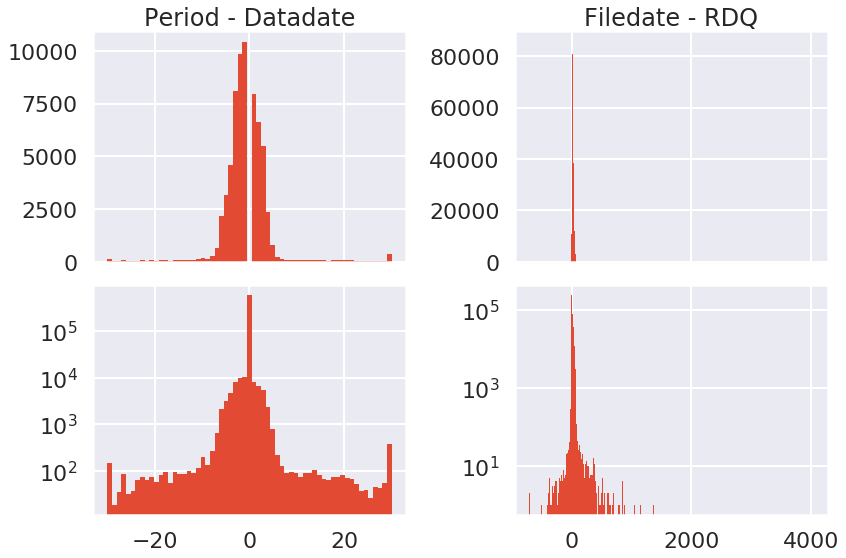

In [137]:
# Plot the date-matches
sns.set_context('poster', rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(12, 8))
d = (df_all[df_all.period.notnull()].period - df_all[df_all.period.notnull()].datadate) / TD_DAY
plt.subplot(221)
d[d != 0].hist(bins=len(d.unique()))
plt.title("Period - Datadate")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(223)
d.hist(bins=len(d.unique()))
plt.yscale('log')

d = (df_all[df_all.rdq.notnull()].filedate - df_all[df_all.rdq.notnull()].rdq) / TD_DAY
plt.subplot(222)
d[~d.isin((0,1))].hist(bins=len(d.unique()))
plt.title("Filedate - RDQ")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(224)
d.hist(bins=len(d.unique()))
plt.yscale('log')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95,
                    hspace=0.1, wspace=0.35)

plt.show()

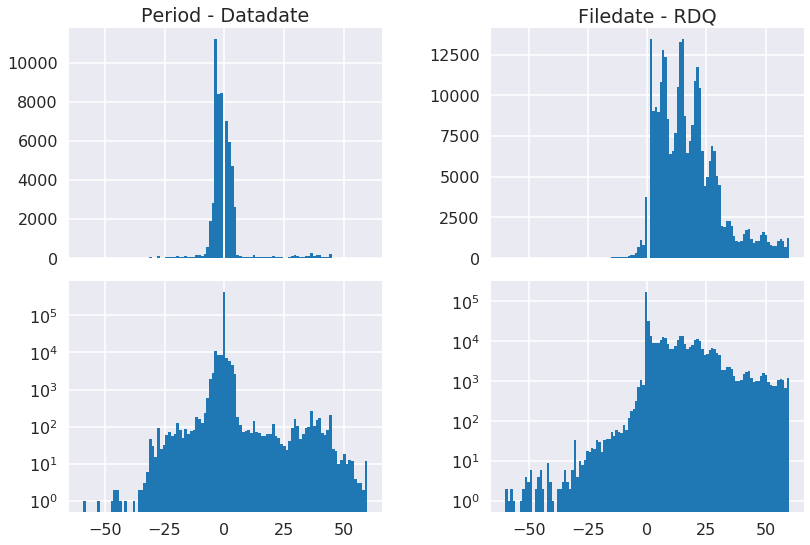

In [239]:
# Plot the date-matches
sns.set_context('poster')
plt.figure(figsize=(12, 8))
d = (df_all[df_all.period.notnull()].period - df_all[df_all.period.notnull()].datadate) / TD_DAY
plt.subplot(221)
d[d != 0].hist(bins=len(d.unique()))
plt.title("Period - Datadate")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(223)
d.hist(bins=len(d.unique()))
plt.yscale('log')

d = (df_all[df_all.rdq.notnull()].filedate - df_all[df_all.rdq.notnull()].rdq) / TD_DAY
plt.subplot(222)
d[~d.isin((0,1))].hist(bins=len(d.unique()))
plt.title("Filedate - RDQ")
plt.gca().get_xaxis().set_ticklabels([])

plt.subplot(224)
d.hist(bins=len(d.unique()))
plt.yscale('log')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95,
                    hspace=0.1, wspace=0.35)

plt.show()